In [139]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization
from tensorflow.keras.optimizers import Adam
from tensorflow.random import set_seed
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from itertools import product
from sklearn import linear_model
from sklearn import feature_selection
import datetime
import pickle

# Load and Clean Data

In [2]:
building_raw = pd.read_csv('building_fire_risk.csv')
demo_raw = pd.read_csv('demographic_data/nyc_demographic_data.csv')
eco_raw = pd.read_csv('nyc_economic_data.csv')
fire_inc_all_raw = pd.read_csv('FireIncidenceAll.csv')
fire_inc_high_raw = pd.read_csv('HighRiskData.csv')
fire_inc_low_raw = pd.read_csv('LowRiskData.csv')

#### Demographic data (demo)

In [3]:
# Remove 'Total_Language_Population' column because all values are NaN and
# 'Median_Year_Built' because data is already captured in building data
demo = demo_raw.drop(['Total_Language_Population', 'Median_Year_Built'], axis=1)
demo.sample(5)

,ZIP,Total_Population,Median_Age,Male_Population,Female_Population,White,Black,American_Indian_Alaska_Native,Asian,Native_Hawaiian_Pacific_Islander,...,Not_in_Labor_Force,Employed,Unemployed,Median_Travel_Time,Total_With_Disability,No_Health_Insurance,Vehicles_Available,Foreign_Born,Median_Earnings,Households_with_Broadband
41,10301,38001,38.4,18402,19599,21927,8300,25,3009,6,...,18001,17959,986,15261,37088,0,14466,8633,51630,11349
40,10282,6086,37.5,3165,2921,4670,139,0,998,0,...,3435,3435,87,3103,6086,0,2499,1290,160313,2435
25,10029,74617,37.2,33488,41129,23188,23400,549,8142,125,...,33103,33065,3173,27091,73773,0,31485,18195,42440,24453
144,11379,37780,43.8,18024,19756,28321,377,118,4356,0,...,20102,20069,933,17710,37409,0,13561,13793,51178,11812
135,11368,108661,33.7,56848,51813,34083,10529,998,14467,11,...,56099,56099,2575,50224,108281,38,28163,65136,28530,22122


#### Building data (building)

In [4]:
# Assign risks to each zipcode
# high risk: 5, medium risk: 3, low risk: 1
building = building_raw.copy()
building = building.replace({'high':3, 'medium':2, 'low':1})

# Calculate total risk per zipcode
building['total_risk'] = building['risk'] * building['count']
build_risks = building.groupby('zipcode').sum()['total_risk']
building = building.merge(build_risks, on='zipcode', how='left').drop(['risk', 'count', 'total_risk_x'], axis=1).rename({'total_risk_y':'total_risk'}, axis=1)
building.drop_duplicates(inplace=True)

# Assign area_mile2 to zipcodes without value. Use minimum area_mile2 / 2
new_area_mile2 = building_raw.area_mile2.min() / 2
building.area_mile2 = building.area_mile2.fillna(new_area_mile2)

# Calculate average risk per zipcode
building['avg_build_risk'] = building.apply(lambda x: round(x['total_risk'] / x['area_mile2'], 3), axis=1)

# Keep useful columns and rename zipcode to ZIP to be consistent with other datasets
building = building[['zipcode', 'avg_build_risk']].rename({'zipcode': 'ZIP'}, axis=1)

building.sample(5)

C:\Users\kevin\AppData\Local\Temp\ipykernel_11252\2515830439.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  building = building.replace({'high':3, 'medium':2, 'low':1})


,ZIP,avg_build_risk
529,11418,13252.397
183,10307,5640.856
99,10036,6643.000
421,11239,500.750
147,10155,1438.217


#### Economic data (eco)

In [5]:
eco = eco_raw.copy()
# Extract useful columns
eco = eco[['ZIP', 'est_households_total', 'est_households_median_income_dollars', 'est_households_mean_income_dollars', 
          'est_families_total', 'est_families_median_income_dollars', 'est_families_mean_income_dollars', 
          'est_married_couple_families_total', 'est_married_couple_families_median_income_dollars', 'est_married_couple_families_mean_income_dollars',
          'est_nonfamily_households_total', 'est_nonfamily_households_median_income_dollars', 'est_nonfamily_households_mean_income_dollars']]
eco.sample(5)

,ZIP,est_households_total,est_households_median_income_dollars,est_households_mean_income_dollars,est_families_total,est_families_median_income_dollars,est_families_mean_income_dollars,est_married_couple_families_total,est_married_couple_families_median_income_dollars,est_married_couple_families_mean_income_dollars,est_nonfamily_households_total,est_nonfamily_households_median_income_dollars,est_nonfamily_households_mean_income_dollars
65,10463,29575,72952.0,101956,16495,84178.0,122236,9096,126204.0,NaN,13080,56527,73152
10,10012,11909,130938.0,219222,3593,210813.0,319316,2842,241176.0,NaN,8316,115181,175267
143,11377,33371,73292.0,105205,19122,82230.0,121433,12796,93783.0,140638.0,14249,54282,72416
108,11225,24747,85201.0,111100,12582,94713.0,124976,6622,109614.0,NaN,12165,72834,91235
95,11212,32588,40060.0,58158,19972,47405.0,66064,5595,78388.0,NaN,12616,20784,38374


#### Fire Incident Data

In [6]:
# Extract useful columns
fire_inc_all = fire_inc_all_raw[['MODZCTA', 'Count']].rename({'MODZCTA':'ZIP', 'Count':'all_incident'}, axis=1)
fire_inc_low = fire_inc_low_raw[['MODZCTA', 'Count']].rename({'MODZCTA':'ZIP', 'Count':'low_incident'}, axis=1)
fire_inc_high = fire_inc_high_raw[['MODZCTA', 'Count']].rename({'MODZCTA':'ZIP', 'Count':'high_incident'}, axis=1)

In [7]:
# Combine all data and calculate medium risk incidents
inc = fire_inc_all.merge(fire_inc_low, on='ZIP', how='left')
inc = inc.merge(fire_inc_high, on='ZIP', how='left')
inc['med_incident'] = inc['all_incident'] - inc['high_incident'] - inc['low_incident']
inc.drop('all_incident', inplace=True, axis=1)

In [8]:
# Assign risks to each zipcode
risk_factor = {'high':3, 'medium':2, 'low':1}
inc['fire_incident_risk'] = inc['high_incident'] * risk_factor['high'] \
                            + inc['med_incident'] * risk_factor['medium'] \
                            + inc['low_incident'] * risk_factor['low']
# Drop 'low_incident', 'med_incident', 'high_incident' columns
inc = inc[['ZIP', 'fire_incident_risk']]
inc.sample(5)

,ZIP,fire_incident_risk
66,10461,10841
150,11411,3148
154,11415,2823
142,11372,8017
0,10001,14028


# Combine Data

In [9]:
# demo + building = df
df = demo.merge(building, on='ZIP')

# df + eco = df
df = df.merge(eco, on='ZIP')

# df + inc = df
df = df.merge(inc, on='ZIP')

df.sample(5)

,ZIP,Total_Population,Median_Age,Male_Population,Female_Population,White,Black,American_Indian_Alaska_Native,Asian,Native_Hawaiian_Pacific_Islander,...,est_families_total,est_families_median_income_dollars,est_families_mean_income_dollars,est_married_couple_families_total,est_married_couple_families_median_income_dollars,est_married_couple_families_mean_income_dollars,est_nonfamily_households_total,est_nonfamily_households_median_income_dollars,est_nonfamily_households_mean_income_dollars,fire_incident_risk
24,10028,47962,40.0,21263,26699,40441,847,0,4990,0,...,10580,NaN,464064,9481,NaN,NaN,14321,106564,147398,5544
136,11369,30693,40.5,15493,15200,7943,5126,128,4493,6,...,7460,83071.0,99779,4219,91081.0,108969.0,2671,65792,68528,5044
16,10019,45521,39.5,24381,21140,30126,2453,263,8496,35,...,7667,178940.0,303842,5699,242898.0,NaN,19233,103502,156350,16656
11,10013,28657,39.2,14345,14312,17734,940,30,8115,0,...,6489,209681.0,527271,5296,NaN,NaN,6120,122479,233573,9488
67,10465,45066,39.6,22015,23051,25152,5947,10,1932,8,...,11065,109012.0,123531,6638,141229.0,NaN,5156,38817,71048,10017


# Prep Data for Model

In [10]:
df.isna().sum()

ZIP                                                    0
Total_Population                                       0
Median_Age                                             0
Male_Population                                        0
Female_Population                                      0
White                                                  0
Black                                                  0
American_Indian_Alaska_Native                          0
Asian                                                  0
Native_Hawaiian_Pacific_Islander                       0
Other_Race                                             0
Two_or_More_Races                                      0
Median_Household_Income                                0
Poverty_Total                                          0
Below_Poverty                                          0
Total_Educ_25plus                                      0
Bachelor_Degree                                        0
Advanced_Degree                

In [11]:
# Remove 'est_married_couple_families_median_income_dollars' and 
# 'est_married_couple_families_mean_income_dollars' column because 141 and 22 rows are NA's
df.drop(['est_married_couple_families_median_income_dollars', 'est_married_couple_families_mean_income_dollars']
        , axis=1, inplace=True)

In [12]:
# est_households_median_income_dollars: 2 NA's
# Use avg ratio of est_households_median_income_dollars and est_households_mean_income_dollars to imputate missing values
ratio = np.mean(df.est_households_median_income_dollars / df.est_households_mean_income_dollars)
df.est_households_median_income_dollars = df.est_households_median_income_dollars.fillna(df.est_households_mean_income_dollars * ratio)
# est_families_median_income_dollars: 14 NA's
# Use avg ratio of est_families_median_income_dollars and est_families_mean_income_dollars to imputate missing values
ratio = np.mean(df.est_families_median_income_dollars / df.est_families_mean_income_dollars)
df.est_families_median_income_dollars = df.est_families_median_income_dollars.fillna(df.est_families_mean_income_dollars * ratio)


In [13]:
train_data = df.sample(frac=0.75, random_state=6242)
test_data = df.drop(train_data.index)
X_train = train_data.drop(['ZIP', 'fire_incident_risk'], axis=1)
y_train = train_data['fire_incident_risk']
X_test = test_data.drop(['ZIP', 'fire_incident_risk'], axis=1)
y_test = test_data['fire_incident_risk']

In [14]:
# Normalize data
normalizer = Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

# DNN Prediction Model without Temporal Data

In [22]:
def build_and_compile_model(norm, n_hidden, n_nodes, learning_rate):
    model = Sequential([norm])
    for i in range(n_hidden):
        model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error',
                optimizer=Adam(learning_rate=learning_rate))
    return model

In [42]:
# Create dataframe to store R^2
model_r2 = pd.DataFrame(columns=['n_hidden', 'n_nodes', 'learning_rate', 'R2'])
# Optimal number of layers
n_hidden = [15, 20, 25, 30]
n_nodes = [10, 20, 30, 40, 50, 60]
all_learning_rates = [0.001, 0.004, 0.008, 0.01, 0.04, 0.08]
best_r2 = 0


########### Uncomment to run - may take hours to run ##############

# for lr in all_learning_rates:
#     for n_node in n_nodes:
#         for i in n_hidden:
#             dnn_model = build_and_compile_model(normalizer, i, n_node, lr)
#             dnn_model.fit(X_train, y_train, validation_split=0.2, verbose=0, epochs=100)
#             r2 = metrics.r2_score(y_test, dnn_model.predict(X_test, verbose=0).flatten())
#             model_r2 = pd.concat([model_r2, pd.DataFrame.from_dict({'n_hidden':[i], 'n_nodes':[n_node], 'learning_rate':[lr], 'R2':[r2]})])
#             if r2 > best_r2:
#                 best_model = dnn_model
#                 best_r2 = r2
# best_model.save('dnn_model.keras')  ## Save model

####################################################################

In [43]:
model_r2.sort_values('R2', ascending=False).head(10)

,n_hidden,n_nodes,learning_rate,R2
0,15,60,0.080,0.886072
0,25,40,0.008,0.871793
0,15,20,0.008,0.868164
0,15,40,0.040,0.854911
0,15,30,0.040,0.853881
0,20,20,0.010,0.848258
0,25,30,0.040,0.842236
0,15,30,0.040,0.841533
0,15,20,0.004,0.836233
0,15,50,0.040,0.834055


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


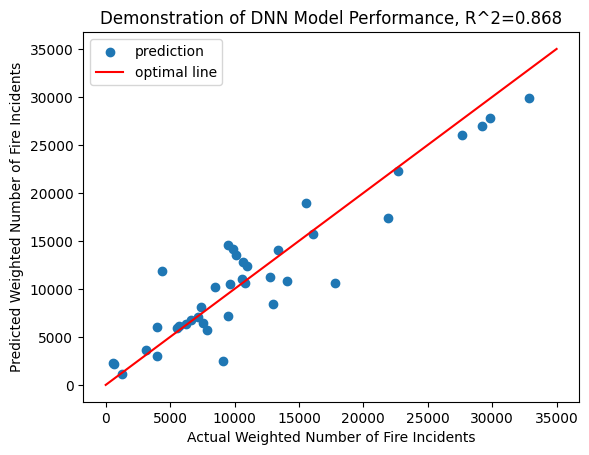

In [45]:
# Demonstrate performance of the best model
R2 = round(metrics.r2_score(y_test, best_model.predict(X_test).flatten()), 3)
plt.scatter(y_test, best_model.predict(X_test).flatten(), label='prediction');
plt.plot([0, 35000], [0, 35000], color='red', label='optimal line');
plt.xlabel('Actual Weighted Number of Fire Incidents');
plt.ylabel('Predicted Weighted Number of Fire Incidents');
plt.title(f'Demonstration of DNN Model Performance, R^2={R2}');
plt.legend();

# DNN Prediction Model with Temporal Data

### Load and Clean Data

In [15]:
# Load data
high_temp = pd.read_csv('HighRiskData_Temporal.csv')

df_1 = pd.read_csv('MediumRiskData_Temporal_1.csv')
df_2 = pd.read_csv('MediumRiskData_Temporal_2.csv')
med_temp = pd.concat([df_1, df_2], ignore_index=True)

df_1 = pd.read_csv('LowRiskData_Temporal_1.csv')
df_2 = pd.read_csv('LowRiskData_Temporal_2.csv')
low_temp = pd.concat([df_1, df_2], ignore_index=True)

In [16]:
# Rename columns
high_temp.rename(columns={"Count":"Count_high"}, inplace=True)
med_temp.rename(columns={"Count":"Count_med"}, inplace=True)
low_temp.rename(columns={"Count":"Count_low"}, inplace=True)

In [17]:
# Combine dateframes
df = low_temp.merge(med_temp, on=['MODZCTA', 'Month', 'Date', 'Year', 'Hour'], how='outer')
df = df.merge(high_temp, on=['MODZCTA', 'Month', 'Date', 'Year', 'Hour'], how='outer')
df = df.fillna(0)
# Keep valid longitude (positive numbers) and latitude (negative numbers)
df['Latitude'] = df.apply(lambda x: min(x['Latitude'], x['Latitude_x'], x['Latitude_y']) , axis=1)
df['Longitude'] = df.apply(lambda x: max(x['Longitude'], x['Longitude_x'], x['Longitude_y']) , axis=1)
df = df.drop(['Latitude_x', 'Latitude_y', 'Longitude_x', 'Longitude_y'], axis=1)
# Convert datatype of zipcode to integer
df['MODZCTA'] = df['MODZCTA'].astype("int")
# Create "risk_adjusted" incident count column
df['Count_adj'] = df['Count_high'] * 3 + df['Count_med'] * 2 + df['Count_low'] * 1


# # Add day of week column (DoW)
# df['DoW'] = df.apply(lambda x: str(int(x.Year)) + '-' + str(int(x.Month)) + '-' + str(int(x.Date)), axis=1)
# df['DoW'] = df['DoW'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").date().strftime("%A"))
# # Get dummy variables for DoW
# df = pd.get_dummies(df, columns=['DoW'])

### Build Models
#### Count_adj

In [121]:
train_data = df.sample(frac=0.75, random_state=6242)
test_data = df.drop(train_data.index)
X_train = train_data.drop(['MODZCTA', 'Count_high', 'Count_med', 'Count_low', 'Count_adj'], axis=1)
y_train = train_data['Count_adj']
X_test = test_data.drop(['MODZCTA', 'Count_high', 'Count_med', 'Count_low', 'Count_adj'], axis=1)
y_test = test_data['Count_adj']
# Normalize data
normalizer = Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

In [123]:
def build_and_compile_temp_model(norm, n_hidden, n_nodes, learning_rate):
    model = Sequential([norm])
    for i in range(n_hidden):
        model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error',
                optimizer=Adam(learning_rate=learning_rate))
    return model

In [124]:
# Optimal number of layers
n_hidden = [10, 50]
n_nodes = [10, 50]
all_learning_rates = [0.0001, 0.001]
best_r2 = 0
# Create dataframe to store R^2
model_r2 = pd.DataFrame(columns=['n_hidden', 'n_nodes', 'learning_rate', 'R2'])

########### Uncomment to run - may take hours to run ##############

for lr in all_learning_rates:
    for n_node in n_nodes:
        for i in n_hidden:
            dnn_model = build_and_compile_temp_model(normalizer, i, n_node, lr)
            dnn_model.fit(X_train, y_train, validation_split=0.2, verbose=0, epochs=100)
            r2 = metrics.r2_score(y_test, dnn_model.predict(X_test, verbose=0).flatten())
            model_r2 = pd.concat([model_r2, pd.DataFrame.from_dict({'n_hidden':[i], 'n_nodes':[n_node], 'learning_rate':[lr], 'R2':[r2]})])
            if r2 > best_r2:
                best_model = dnn_model
                best_r2 = r2
            print(i, n_node, lr, r2)

####################################################################

C:\Users\kevin\AppData\Local\Temp\ipykernel_10100\3748305602.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_r2 = pd.concat([model_r2, pd.DataFrame.from_dict({'n_hidden':[i], 'n_nodes':[n_node], 'learning_rate':[lr], 'R2':[r2]})])


10 10 0.0001 -0.08347449942960905
50 10 0.0001 -0.15450122926160836


KeyboardInterrupt: 

In [133]:
best_model.save('temporal_adj_dnn_model.keras')

#### The DNN model with temporal features had no predictive power. Therefore, I'll try to implement logistic regression since most numbers of incident per zipcode per hour is 0 or 1.
# Logistic Regression Implementation
### Data Clenaing
 - **Drop Year**: In order to include predictive power of the logistic regression model, we must drop the Year feature.
 - **Include 0s**: If there was not an incident, it was not included in the table as 0.
 - **Drop Latitude, Longitude**: Create dummy variable and use MODZCTA as location feature.
 - **Replace values > 1 with 1**: Due to the nature of logistic regression, I'll replace number of incidents greater than 1 with 1.
 - **Wavelet data**: Include wavelet data as features

In [106]:
# Drop Year
df_log = df.drop(['Year'], axis=1)

# Create new dataframe that includes all hours, days, months, and zipcodes
zipcodes = df.MODZCTA.unique()
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
dates = list(range(1, 32))
hours = list(range(24))
df_all = pd.DataFrame(list(product(zipcodes, months, dates, hours)), columns=['MODZCTA', 'Month', 'Date', 'Hour'])

# Remove non-exist dates (2/29, 2/30, 2/31, 4/31, 6/31, 9/31, 11/31)
df_all = df_all[~(((df_all.Month == 2) & (df_all.Date >= 29)) |  # 2/29, 2/30, 2/31
        (((df_all.Month == 4) | (df_all.Month == 6) | (df_all.Month == 9) | (df_all.Month == 11)) & (df_all.Date == 31)))]# 4/31, 6/31, 9/31, 11/31

# Merge with incident data
df_all = df_all.merge(df_log, on=['MODZCTA', 'Month', 'Date', 'Hour'], how='left')

# Drop Latitude and Longitude columns. Use MODZCTA as the location predicting var
df_all = df_all.drop(['Latitude', 'Longitude'], axis=1)

# Fill nan as 0
df_all = df_all.fillna(0)

# Group hours (every 4 hours)
hour_increment = 4
df_all['Hour_group'] = df_all['Hour'].apply(lambda x: (x//hour_increment) * hour_increment)
df_grouped = df_all.drop('Hour', axis=1).groupby(['Month', 'Date', 'Hour_group', 'MODZCTA'], as_index=False).sum()

# Load wavelet data and merge with df_all and df_grouped
wavelet = pd.read_csv('wavelet_features.csv')
df_grouped = df_grouped.merge(wavelet, on='MODZCTA', how='left')
df_all = df_all.merge(wavelet, on='MODZCTA', how='left')

# Create dummy variables for month & date
df_grouped = pd.get_dummies(df_grouped, columns=['Month', 'Date', 'Hour_group'])
df_all = pd.get_dummies(df_all, columns=['Month', 'Date', 'Hour_group'])

# Create dummy variables for MODZCTA for df_all and df_grouped or 
## drop MODZCTA since it's already included in wavelet data
option = 'drop' # Choose either 'keep' or 'drop'
if option == 'keep':
    df_grouped = pd.get_dummies(df_grouped, columns=['MODZCTA'])
    df_all = pd.get_dummies(df_all, columns=['MODZCTA'])
elif option == 'drop':
    df_grouped = df_grouped.drop('MODZCTA', axis=1)
    df_all = df_all.drop('MODZCTA', axis=1)


In [107]:
# Replace values > 1 with 1
df_all['Count_low_1'] = df_all['Count_low'].apply(lambda x: int(x > 0))
df_all['Count_med_1'] = df_all['Count_med'].apply(lambda x: int(x > 0))
df_all['Count_high_1'] = df_all['Count_high'].apply(lambda x: int(x > 0))
df_all['Count_any'] = df_all['Count_adj'].apply(lambda x: int(x > 0))

### Logistic Model
#### Include all varaibles

In [108]:
## Low risk incidents

# Prep data
train_data = df_all.sample(frac=0.75, random_state=6242)
test_data = df_all.drop(train_data.index)
X_train = train_data.drop(['Hour', 'Count_high', 'Count_med', 'Count_low', 'Count_adj', 'Count_high_1', 'Count_med_1', 'Count_low_1', 'Count_any'], axis=1)
y_train = train_data['Count_low_1']
X_test = test_data.drop(['Hour', 'Count_high', 'Count_med', 'Count_low', 'Count_adj', 'Count_high_1', 'Count_med_1', 'Count_low_1', 'Count_any'], axis=1)
y_test = test_data['Count_low_1']

# Build model
lr_low = linear_model.LogisticRegression(max_iter=1000).fit(X_train, y_train)

# Evaluate model
score_low_all = lr_low.score(X_test, y_test)
score_low_all

0.6835023872912496

In [109]:
## Medium risk incidents

# Prep data
train_data = df_all.sample(frac=0.75, random_state=6242)
test_data = df_all.drop(train_data.index)
X_train = train_data.drop(['Hour', 'Count_high', 'Count_med', 'Count_low', 'Count_adj', 'Count_high_1', 'Count_med_1', 'Count_low_1', 'Count_any'], axis=1)
y_train = train_data['Count_med_1']
X_test = test_data.drop(['Hour', 'Count_high', 'Count_med', 'Count_low', 'Count_adj', 'Count_high_1', 'Count_med_1', 'Count_low_1', 'Count_any'], axis=1)
y_test = test_data['Count_med_1']

# Build model
lr_med = linear_model.LogisticRegression(max_iter=1000).fit(X_train, y_train)

# Evaluate model
score_med_all = lr_med.score(X_test, y_test)
score_med_all

C:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7622917995995512

In [110]:
## High risk incidents

# Prep data
train_data = df_all.sample(frac=0.75, random_state=6242)
test_data = df_all.drop(train_data.index)
X_train = train_data.drop(['Hour', 'Count_high', 'Count_med', 'Count_low', 'Count_adj', 'Count_high_1', 'Count_med_1', 'Count_low_1', 'Count_any'], axis=1)
y_train = train_data['Count_high_1']
X_test = test_data.drop(['Hour', 'Count_high', 'Count_med', 'Count_low', 'Count_adj', 'Count_high_1', 'Count_med_1', 'Count_low_1', 'Count_any'], axis=1)
y_test = test_data['Count_high_1']

# Build model
lr_high = linear_model.LogisticRegression(max_iter=1000).fit(X_train, y_train)

# Evaluate model
score_high_all = lr_high.score(X_test, y_test)
score_high_all

0.9685581640960197

In [111]:
## Any incidents

# Prep data
train_data = df_all.sample(frac=0.75, random_state=6242)
test_data = df_all.drop(train_data.index)
X_train = train_data.drop(['Hour', 'Count_high', 'Count_med', 'Count_low', 'Count_adj', 'Count_high_1', 'Count_med_1', 'Count_low_1', 'Count_any'], axis=1)
y_train = train_data['Count_any']
X_test = test_data.drop(['Hour', 'Count_high', 'Count_med', 'Count_low', 'Count_adj', 'Count_high_1', 'Count_med_1', 'Count_low_1', 'Count_any'], axis=1)
y_test = test_data['Count_any']

# Build model
lr_any = linear_model.LogisticRegression(max_iter=1000).fit(X_train, y_train)

# Evaluate model
score_any_all = lr_any.score(X_test, y_test)
score_any_all

C:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7174723316244582

In [140]:
# Save models
with open('low_risk_logistic.pkl','wb') as f:
    pickle.dump(lr_low,f)
with open('med_risk_logistic.pkl','wb') as f:
    pickle.dump(lr_med,f)
with open('high_risk_logistic.pkl','wb') as f:
    pickle.dump(lr_high,f)
with open('any_risk_logistic.pkl','wb') as f:
    pickle.dump(lr_any,f)

### Variable Selection
The models above used all (180) variables, and in order to reduce complexity of the model, recursive feature elimination (RFE) was used to perform variable selection

In [134]:
## Low risk incidents

# Prep data
train_data = df_all.sample(frac=0.75, random_state=6242)
test_data = df_all.drop(train_data.index)
X_train = train_data.drop(['Hour', 'Count_high', 'Count_med', 'Count_low', 'Count_adj', 'Count_high_1', 'Count_med_1', 'Count_low_1', 'Count_any'], axis=1)
y_train = train_data['Count_low_1']
X_test = test_data.drop(['Hour', 'Count_high', 'Count_med', 'Count_low', 'Count_adj', 'Count_high_1', 'Count_med_1', 'Count_low_1', 'Count_any'], axis=1)
y_test = test_data['Count_low_1']

# Variable Selection
lr = linear_model.LogisticRegression(max_iter=1000)
n_feat = 20
rfe = feature_selection.RFE(estimator=lr, n_features_to_select=n_feat)
rfe.fit(X_train, y_train)
selected_features = X_train.columns[rfe.support_]
print("Selected features:", selected_features)

# Build model
lr_low_reduced = linear_model.LogisticRegression(max_iter=1000).fit(X_train[selected_features], y_train)

# Evaluate and compare models
score_low_reduced = lr_low_reduced.score(X_test[selected_features], y_test)
print(f"R2 with all vars: {round(score_low_all, 3)}, with top {n_feat} vars: {round(score_low_reduced, 3)}")

C:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Selected features: Index(['high_mean_energy', 'high_max_energy', 'med_mean_energy',
       'med_max_energy', 'low_mean_energy', 'low_max_energy', 'Month_2',
       'Month_3', 'Month_4', 'Month_6', 'Month_7', 'Month_8', 'Month_9',
       'Month_10', 'Month_12', 'Hour_group_0', 'Hour_group_4', 'Hour_group_8',
       'Hour_group_12', 'Hour_group_16'],
      dtype='object')
R2 with all vars: 0.684, with top 20 vars: 0.683


In [135]:
## Medium risk incidents

# Prep data
train_data = df_all.sample(frac=0.75, random_state=6242)
test_data = df_all.drop(train_data.index)
X_train = train_data.drop(['Hour', 'Count_high', 'Count_med', 'Count_low', 'Count_adj', 'Count_high_1', 'Count_med_1', 'Count_low_1', 'Count_any'], axis=1)
y_train = train_data['Count_med_1']
X_test = test_data.drop(['Hour', 'Count_high', 'Count_med', 'Count_low', 'Count_adj', 'Count_high_1', 'Count_med_1', 'Count_low_1', 'Count_any'], axis=1)
y_test = test_data['Count_med_1']

# Variable Selection
lr = linear_model.LogisticRegression(max_iter=1000)
n_feat = 20
rfe = feature_selection.RFE(estimator=lr, n_features_to_select=n_feat)
rfe.fit(X_train, y_train)
selected_features = X_train.columns[rfe.support_]
print("Selected features:", selected_features)

# Build model
lr_med_reduced = linear_model.LogisticRegression(max_iter=1000).fit(X_train[selected_features], y_train)

# Evaluate and compare models
score_med_reduced = lr_med_reduced.score(X_test[selected_features], y_test)
print(f"R2 with all vars: {round(score_med_all, 3)}, with top {n_feat} vars: {round(score_med_reduced, 3)}")

C:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Selected features: Index(['high_mean_energy', 'high_max_energy', 'med_mean_energy',
       'med_max_energy', 'low_mean_energy', 'low_max_energy', 'Month_2',
       'Month_3', 'Month_5', 'Month_7', 'Month_10', 'Month_12', 'Date_7',
       'Date_8', 'Date_13', 'Hour_group_0', 'Hour_group_4', 'Hour_group_8',
       'Hour_group_12', 'Hour_group_16'],
      dtype='object')
R2 with all vars: 0.762, with top 20 vars: 0.762


In [137]:
## High risk incidents

# Prep data
train_data = df_all.sample(frac=0.75, random_state=6242)
test_data = df_all.drop(train_data.index)
X_train = train_data.drop(['Hour', 'Count_high', 'Count_med', 'Count_low', 'Count_adj', 'Count_high_1', 'Count_med_1', 'Count_low_1', 'Count_any'], axis=1)
y_train = train_data['Count_high_1']
X_test = test_data.drop(['Hour', 'Count_high', 'Count_med', 'Count_low', 'Count_adj', 'Count_high_1', 'Count_med_1', 'Count_low_1', 'Count_any'], axis=1)
y_test = test_data['Count_high_1']

# Variable Selection
lr = linear_model.LogisticRegression(max_iter=1000)
n_feat = 20
rfe = feature_selection.RFE(estimator=lr, n_features_to_select=10)
rfe.fit(X_train, y_train)
selected_features = X_train.columns[rfe.support_]
print("Selected features:", selected_features)

# Build model
lr_high_reduced = linear_model.LogisticRegression(max_iter=1000).fit(X_train[selected_features], y_train)

# Evaluate and compare models
score_high_reduced = lr_high_reduced.score(X_test[selected_features], y_test)
print(f"R2 with all vars: {round(score_high_all, 3)}, with top {n_feat} vars: {round(score_high_reduced, 3)}")

Selected features: Index(['high_mean_energy', 'med_mean_energy', 'low_mean_energy', 'Month_2',
       'Month_11', 'Hour_group_0', 'Hour_group_4', 'Hour_group_8',
       'Hour_group_12', 'Hour_group_16'],
      dtype='object')
R2 with all vars: 0.969, with top 20 vars: 0.969


In [138]:
## Any incidents

# Prep data
train_data = df_all.sample(frac=0.75, random_state=6242)
test_data = df_all.drop(train_data.index)
X_train = train_data.drop(['Hour', 'Count_high', 'Count_med', 'Count_low', 'Count_adj', 'Count_high_1', 'Count_med_1', 'Count_low_1', 'Count_any'], axis=1)
y_train = train_data['Count_any']
X_test = test_data.drop(['Hour', 'Count_high', 'Count_med', 'Count_low', 'Count_adj', 'Count_high_1', 'Count_med_1', 'Count_low_1', 'Count_any'], axis=1)
y_test = test_data['Count_any']

# Variable Selection
lr = linear_model.LogisticRegression(max_iter=500)
n_feat = 20
rfe = feature_selection.RFE(estimator=lr, n_features_to_select=n_feat)
rfe.fit(X_train, y_train)
selected_features = X_train.columns[rfe.support_]
print("Selected features:", selected_features)

# Build model
lr_any_reduced = linear_model.LogisticRegression(max_iter=1000).fit(X_train[selected_features], y_train)

# Evaluate and compare models
score_any_reduced = lr_any_reduced.score(X_test[selected_features], y_test)
print(f"R2 with all vars: {round(score_any_all, 3)}, with top {n_feat} vars: {round(score_any_reduced, 3)}")

C:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Selected features: Index(['high_mean_energy', 'high_max_energy', 'med_mean_energy',
       'med_max_energy', 'low_mean_energy', 'low_max_energy', 'Month_2',
       'Month_3', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10',
       'Month_12', 'Hour_group_0', 'Hour_group_4', 'Hour_group_8',
       'Hour_group_12', 'Hour_group_16', 'Hour_group_20'],
      dtype='object')
R2 with all vars: 0.717, with top 20 vars: 0.716


## Linear Regression

In [115]:
## Adjusted number of incidents

# Prep data
train_data = df_grouped.sample(frac=0.75, random_state=6242)
test_data = df_grouped.drop(train_data.index)
X_train = train_data.drop(['Count_high', 'Count_med', 'Count_low', 'Count_adj'], axis=1)
y_train = train_data['Count_adj']
X_test = test_data.drop(['Count_high', 'Count_med', 'Count_low', 'Count_adj'], axis=1)
y_test = test_data['Count_adj']

# Build model - all vars
lnr_adj = linear_model.LinearRegression().fit(X_train, y_train)

# Evaluate model - all vars
score_adj_all = lnr_adj.score(X_test, y_test)

# Variable Selection
lnr_adj = linear_model.LinearRegression()
n_feat = 10
rfe = feature_selection.RFE(estimator=lnr_adj, n_features_to_select=n_feat)
rfe.fit(X_train, y_train)
selected_features = X_train.columns[rfe.support_]
print("Selected features:", selected_features)

# Build model
lnr_adj_reduced = linear_model.LinearRegression().fit(X_train[selected_features], y_train)
# Evaluate model
score_adj_reduced = lnr_adj_reduced.score(X_test[selected_features], y_test)
print(f"R2 with all vars: {round(score_adj_all, 3)}, with top {n_feat} vars: {round(score_adj_reduced, 3)}")

Selected features: Index(['Date_24', 'Date_29', 'Date_30', 'Date_31', 'Hour_group_0',
       'Hour_group_4', 'Hour_group_8', 'Hour_group_12', 'Hour_group_16',
       'Hour_group_20'],
      dtype='object')
R2 with all vars: 0.437, with top 10 vars: 0.112


In [116]:
## number of incidents - high risk

# Prep data
train_data = df_grouped.sample(frac=0.75, random_state=6242)
test_data = df_grouped.drop(train_data.index)
X_train = train_data.drop(['Count_high', 'Count_med', 'Count_low', 'Count_adj'], axis=1)
y_train = train_data['Count_high']
X_test = test_data.drop(['Count_high', 'Count_med', 'Count_low', 'Count_adj'], axis=1)
y_test = test_data['Count_high']

# Build model - all vars
lnr_adj = linear_model.LinearRegression().fit(X_train, y_train)

# Evaluate model - all vars
score_adj_all = lnr_adj.score(X_test, y_test)

# Variable Selection
lnr_adj = linear_model.LinearRegression()
n_feat = 10
rfe = feature_selection.RFE(estimator=lnr_adj, n_features_to_select=n_feat)
rfe.fit(X_train, y_train)
selected_features = X_train.columns[rfe.support_]
print("Selected features:", selected_features)

# Build model
lnr_adj_reduced = linear_model.LinearRegression().fit(X_train[selected_features], y_train)
# Evaluate model
score_adj_reduced = lnr_adj_reduced.score(X_test[selected_features], y_test)
print(f"R2 with all vars: {round(score_adj_all, 3)}, with top {n_feat} vars: {round(score_adj_reduced, 3)}")

Selected features: Index(['Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10'],
      dtype='object')
R2 with all vars: 0.058, with top 10 vars: 0.003


In [117]:
## number of incidents - medium risk

# Prep data
train_data = df_grouped.sample(frac=0.75, random_state=6242)
test_data = df_grouped.drop(train_data.index)
X_train = train_data.drop(['Count_high', 'Count_med', 'Count_low', 'Count_adj'], axis=1)
y_train = train_data['Count_med']
X_test = test_data.drop(['Count_high', 'Count_med', 'Count_low', 'Count_adj'], axis=1)
y_test = test_data['Count_med']

# Build model - all vars
lnr_adj = linear_model.LinearRegression().fit(X_train, y_train)

# Evaluate model - all vars
score_adj_all = lnr_adj.score(X_test, y_test)

# Variable Selection
lnr_adj = linear_model.LinearRegression()
n_feat = 10
rfe = feature_selection.RFE(estimator=lnr_adj, n_features_to_select=n_feat)
rfe.fit(X_train, y_train)
selected_features = X_train.columns[rfe.support_]
print("Selected features:", selected_features)

# Build model
lnr_adj_reduced = linear_model.LinearRegression().fit(X_train[selected_features], y_train)
# Evaluate model
score_adj_reduced = lnr_adj_reduced.score(X_test[selected_features], y_test)
print(f"R2 with all vars: {round(score_adj_all, 3)}, with top {n_feat} vars: {round(score_adj_reduced, 3)}")

Selected features: Index(['Date_7', 'Date_8', 'Date_12', 'Date_17', 'Hour_group_0',
       'Hour_group_4', 'Hour_group_8', 'Hour_group_12', 'Hour_group_16',
       'Hour_group_20'],
      dtype='object')
R2 with all vars: 0.312, with top 10 vars: 0.08


In [118]:
## number of incidents - low risk

# Prep data
train_data = df_grouped.sample(frac=0.75, random_state=6242)
test_data = df_grouped.drop(train_data.index)
X_train = train_data.drop(['Count_high', 'Count_med', 'Count_low', 'Count_adj'], axis=1)
y_train = train_data['Count_low']
X_test = test_data.drop(['Count_high', 'Count_med', 'Count_low', 'Count_adj'], axis=1)
y_test = test_data['Count_low']

# Build model - all vars
lnr_adj = linear_model.LinearRegression().fit(X_train, y_train)

# Evaluate model - all vars
score_adj_all = lnr_adj.score(X_test, y_test)

# Variable Selection
lnr_adj = linear_model.LinearRegression()
n_feat = 10
rfe = feature_selection.RFE(estimator=lnr_adj, n_features_to_select=n_feat)
rfe.fit(X_train, y_train)
selected_features = X_train.columns[rfe.support_]
print("Selected features:", selected_features)

# Build model
lnr_adj_reduced = linear_model.LinearRegression().fit(X_train[selected_features], y_train)
# Evaluate model
score_adj_reduced = lnr_adj_reduced.score(X_test[selected_features], y_test)
print(f"R2 with all vars: {round(score_adj_all, 3)}, with top {n_feat} vars: {round(score_adj_reduced, 3)}")

Selected features: Index(['Month_6', 'Month_7', 'Month_8', 'Month_12', 'Hour_group_0',
       'Hour_group_4', 'Hour_group_8', 'Hour_group_12', 'Hour_group_16',
       'Hour_group_20'],
      dtype='object')
R2 with all vars: 0.33, with top 10 vars: 0.079
